In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, AveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns

Task 1 - Importing Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
xray_directory = '/content/drive/MyDrive/Covid-19/Dataset'

In [4]:
image_generator = ImageDataGenerator(rescale=1./255)

In [5]:
train_generator = image_generator.flow_from_directory(batch_size=40, directory=xray_directory, shuffle=True, target_size=(256, 256), class_mode='categorical', subset='training')

Found 532 images belonging to 4 classes.


In [6]:
train_images, train_labels = next(train_generator)

In [7]:
train_images.shape

(40, 256, 256, 3)

In [8]:
labels_name = {0: 'Covid-19', 1: 'Normal', 2: 'Pneumonia viral', 3: 'Pneumonia bacterial'}

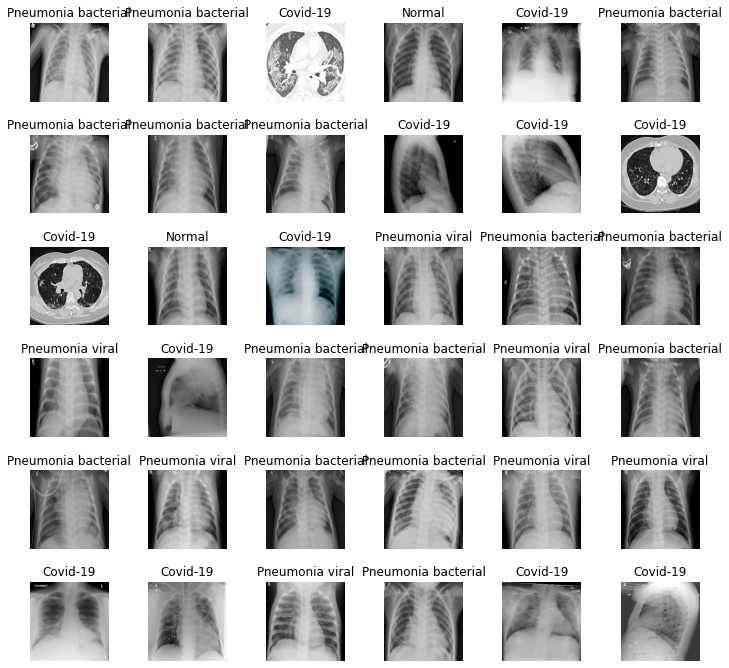

In [9]:
#Showing some images and her categories
figs, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()
for i in np.arange(0, 36):
  axes[i].imshow(train_images[i])
  axes[i].set_title(labels_name[np.argmax(train_labels[i])])
  axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

In [10]:
#Importing pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_tensor= Input(shape=(256,256,3)))

94781440/94765736 [==============================] - 1s 0us/step


In [11]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

Task 2 - Building the model

In [12]:
#Clearing layers so they are not trained except the last 10
for layer in base_model.layers[:-10]:
  layers.trainable = False

In [13]:
#Setting up deep learning with ResNet
head_model = base_model.output
head_model = AveragePooling2D()(head_model)
head_model = Flatten()(head_model)
head_model = Dense(256, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(256, activation='relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(4, activation='softmax')(head_model)

In [14]:
model = Model(inputs = base_model.input, outputs = head_model)

In [15]:
model.compile(loss = 'categorical_crossentropy', optimizer=optimizers.RMSprop(lr = 1e-4, decay=1e-6), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [16]:
#Generating a checkpoint to model
checkpointer = ModelCheckpoint(filepath='weights.hdf5')

In [17]:
train_generator = image_generator.flow_from_directory(batch_size=4, directory=xray_directory, shuffle=True, target_size=(256,256), class_mode='categorical', subset='training')

Found 532 images belonging to 4 classes.


In [18]:
#Training the model
history = model.fit_generator(train_generator, epochs=50, callbacks=[checkpointer])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/50
133/133 [==============================] - ETA: 0s - loss: 0.9336 - accuracy: 0.7556

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


133/133 [==============================] - 468s 3s/step - loss: 0.9336 - accuracy: 0.7556
Epoch 2/50
133/133 [==============================] - 450s 3s/step - loss: 0.5401 - accuracy: 0.8741
Epoch 3/50
133/133 [==============================] - 453s 3s/step - loss: 0.3429 - accuracy: 0.9248
Epoch 4/50
133/133 [==============================] - 451s 3s/step - loss: 0.3088 - accuracy: 0.9417
Epoch 5/50
133/133 [==============================] - 451s 3s/step - loss: 0.1841 - accuracy: 0.9756
Epoch 6/50
133/133 [==============================] - 453s 3s/step - loss: 0.2328 - accuracy: 0.9605
Epoch 7/50
133/133 [==============================] - 455s 3s/step - loss: 0.2406 - accuracy: 0.9643
Epoch 8/50
133/133 [==============================] - 455s 3s/step - loss: 0.1687 - accuracy: 0.9699
Epoch 9/50
133/133 [==============================] - 453s 3s/step - loss: 0.1724 - accuracy: 0.9718
Epoch 10/50
133/133 [==============================] - 453s 3s/step - loss: 0.1419 - accuracy: 0.9793


In [19]:
test_directory = '/content/drive/MyDrive/Covid-19/Test'

Task 3 - Testing images

In [20]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_directory(batch_size=40, directory=test_directory, shuffle=True, target_size=(256, 256), class_mode='categorical')

Found 40 images belonging to 4 classes.


In [21]:
evaluate = model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


In [22]:
#Setting images in a list
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory, str(i))):
    img = cv2.imread(os.path.join(test_directory, str(i), item))
    img = cv2.resize(img, (256, 256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1, 256, 256, 3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [24]:
#Accuracy score of model
accuracy_score(original, prediction)

0.8

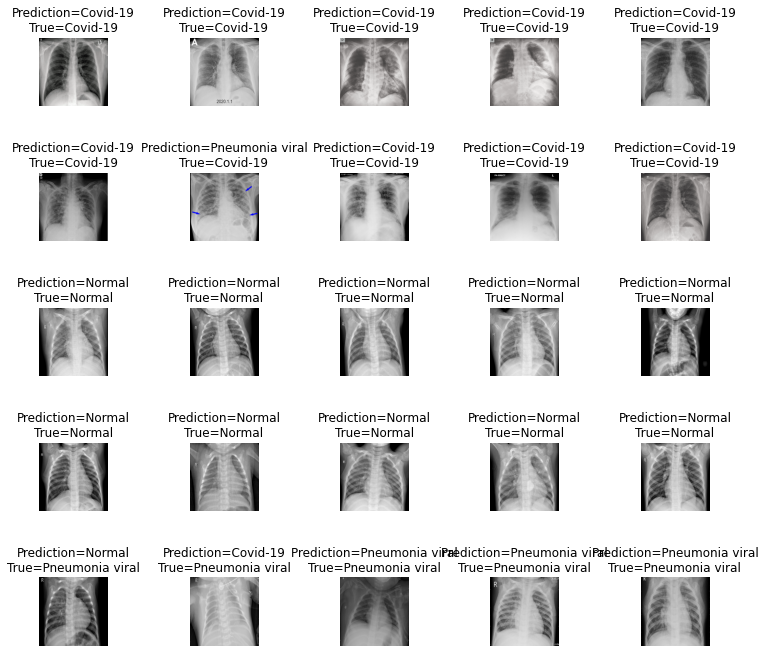

In [25]:
#Showing the images and her predictions
fig, axes = plt.subplots(5, 5, figsize=(12,12))
axes = axes.ravel()
for i in np.arange(0, 25):
  axes[i].imshow(image[i])
  axes[i].set_title('Prediction={}\nTrue={}'.format(str(labels_name[prediction[i]]), str(labels_name[original[i]])))
  axes[i].axis('off')
plt.subplots_adjust(wspace=1.2)

In [26]:
labels_name

{0: 'Covid-19', 1: 'Normal', 2: 'Pneumonia viral', 3: 'Pneumonia bacterial'}

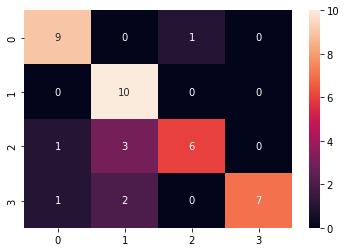

In [27]:
#Generating a confusion matrix
cm = confusion_matrix(original, prediction)
sns.heatmap(cm, annot=True)

In [28]:
#Analyzing classification report (precision and recall)
print(classification_report(original, prediction))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86        10
           1       0.67      1.00      0.80        10
           2       0.86      0.60      0.71        10
           3       1.00      0.70      0.82        10

    accuracy                           0.80        40
   macro avg       0.84      0.80      0.80        40
weighted avg       0.84      0.80      0.80        40



In [29]:
from keras.models import load_model
model_loaded = load_model('/content/weights.hdf5')

In [30]:
model_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

Task 4 - Predicting a image

In [31]:
#Filepath of selected image
img = cv2.imread('/content/drive/MyDrive/Covid-19/Test/0/auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg')

In [32]:
from google.colab.patches import cv2_imshow

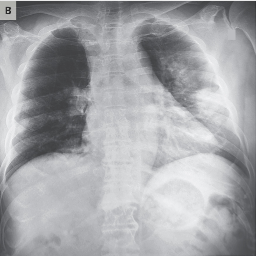

In [33]:
img = cv2.resize(img, (256,256))
cv2_imshow(img)

In [34]:
img = img / 256

In [35]:
img = img.reshape(1, 256, 256, 3)

In [36]:
img.shape

(1, 256, 256, 3)

In [37]:
predict = model_loaded(img)
predict

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[1.0000000e+00, 9.4004305e-33, 1.2826354e-37, 4.2039540e-34]],
      dtype=float32)>

In [38]:
#Predicition
predict = np.argmax(predict)
labels_name[predict]

'Covid-19'